In [25]:
import os 
import pandas as pd 
import numpy as np
import string
#Allows for threads to execute

### Setup Word Embedding Model

In [ ]:
#This captures the individual value for each word rather than the global context
def create_glove_embeddings(file_path):
    index = {}
    with open(file_path, 'r') as file:
        for line in file:
            #contains the word and its GloVe embeddings
            values = line.split()
            word = values[0]
            #Puts the word and its corresponding embedding 
            #a numpy array that represents this words embeddings
            vector = np.asarray(values[1:], dtype='float32')
            #Creates a dictionary (key: word, value: vector of numbers)
            index[word] = vector
    return index

#Loads the embedding model we are using
glove_embeddings = create_glove_embeddings('glove.6B.100d.txt')

### Set up Dataframe

In [ ]:

#Handles converting reviews into vector word embeddings
def review_embedding(review, glove_embeddings, dimension):
    word_embeddings = []
    words = review.split()
    for word in words: 
        #Cleans words - lowers all and gets rid of punctuation
        word = word.lower().strip(string.punctuation)
        #Looks up the word embedding value for each word
        #and sets the word to zero if the word is not found
        embedding = glove_embeddings.get(word, np.zeros(dimension))
        word_embeddings.append(embedding)
        #Averages word embedding vectors in each review
    return np.mean(word_embeddings, axis=0)

#Gets the review from the designated files on desktop
def get_review(folderPath, classification, glove_embeddings):
    data = []
    dimension = 100
    for filename in os.listdir(folderPath):
        if filename.endswith(".txt"): 
            filePath = os.path.join(folderPath, filename)
            with open(filePath, 'r') as file:
                review = file.read().strip()
                #Calls the embedding model to convert the words into vectors
                embedding = review_embedding(review, glove_embeddings, dimension)
                #Appends a list inside of the data list consisting of the embedding vector and classification
                data.append([embedding, classification])
    return data

#1 being positive 0 being negative
positive_data = get_review('train_pos', '1', glove_embeddings)
negative_data = get_review('train_neg', '0', glove_embeddings)

combined_data = positive_data + negative_data
len(combined_data)

25000

### Divide dataframe into test and train data

In [ ]:
from sklearn.model_selection import train_test_split
X = []
y = []

# Iterates through each row in combined data
for review, classification in combined_data:
    #review
    X.append(review)
    #classification
    y.append(classification)

#Creates the train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### SVM: Fitting The Model

In [ ]:
from sklearn import svm
#SVC is support vector classifcation
# kernal: mathematical function to map input to high dimension spaces 
svm_classifier = svm.SVC(kernel = "linear")
svm_classifier.fit(X_train,y_train)

SVC(kernel='linear')

### SVM: Testing the model

In [ ]:
#Creates predictions for the testing data based on the fitted model
predict_svm = svm_classifier.predict(X_test)
print(predict_svm)

['0' '1' '0' ... '1' '1' '1']


### SVM: Accuracy

In [31]:
#Test SVM accuracy
from sklearn.metrics import accuracy_score 
svm_accuracy = accuracy_score(y_test, predict_svm)
print(f"Accuracy of SVM model {svm_accuracy}")

Accuracy of SVM model 0.79696


### K-NN (K-Nearest Neighbor)

In [32]:
#Test for K-NN
from sklearn.neighbors import KNeighborsClassifier 
neigh_classifier = KNeighborsClassifier(n_neighbors=50)
neigh_classifier.fit(X_train,y_train)
predict_knn = neigh_classifier.predict(X_test)
knn_accuracy = accuracy_score(y_test, predict_knn)
print(f"Accuracy of K-nn model {knn_accuracy}")

Accuracy of K-nn model 0.73696


### Gaussian Naive Bayes Classifier 

In [33]:
#Test for Naive Bayes Classifer
from sklearn.naive_bayes import GaussianNB
naive_classifier = GaussianNB()
naive_classifier.fit(X_train,y_train)
predict_naive = naive_classifier.predict(X_test)
naive_accuracy = accuracy_score(y_test, predict_naive)
print(f"Accuracy of K-nn model {naive_accuracy}")

Accuracy of K-nn model 0.6904


### Visual Representation: MatPlotLib

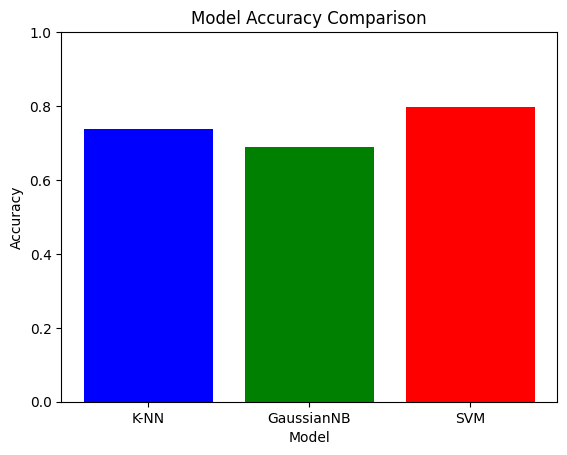

In [ ]:
import matplotlib.pyplot as plt

#Compares the 3 models performances
models = ['K-NN', 'GaussianNB', 'SVM']
accuracies = [knn_accuracy, naive_accuracy, svm_accuracy]

#matplotlib bar graph for performance
plt.figure()
plt.bar(models, accuracies, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Model Accuracy Comparison')

plt.show()

### PCA - Set-up for Dimension Reduction To See The Word Embeddings

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

#Function for PCA dimension reduction
def PCA_set_up(dimensions):
    vectors = []
    classification = []
    
    #Separates the vectors from the classification data
    for item in combined_data:
        vectors.append(item[0])
        classification.append(item[1])

    #Transforms list to numpy array to use PCA
    vectors = np.array(vectors)

    #Reduce dimensionality to 2
    pca = PCA(n_components=dimensions)
    pca_data = pca.fit_transform(vectors)

    positive = []
    negative = []

    #Creates a positive and negative list for the PCA data
    for i in range(len(classification)):
        if classification[i] == "1":
            positive.append(pca_data[i])
        elif classification[i] == "0":
            negative.append(pca_data[i])

    #Converts to numpy array for matplotlib ease of use
    positive = np.array(positive)
    negative = np.array(negative)

    return positive, negative


### PCA - 2D

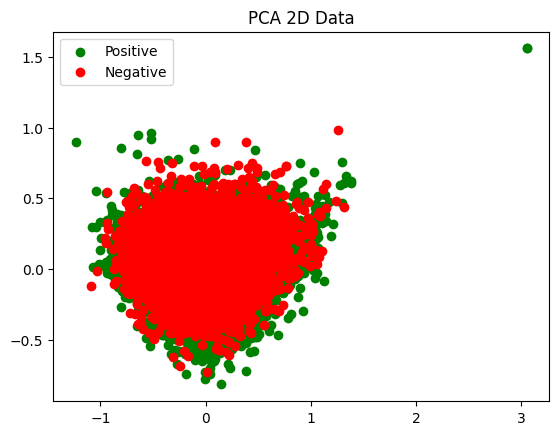

In [38]:
#Gets reduced positive and negative data (2d)
positive, negative = PCA_set_up(2)

#Plots the data
plt.figure()
plt.scatter(positive[:, 0], positive[:, 1], color='green', label='Positive')
plt.scatter(negative[:, 0], negative[:, 1], color='red', label='Negative')
plt.legend()
plt.title('PCA 2D Data')
plt.show()

### PCA - Dimension Reduction To See The Word Embeddings in 3D Space

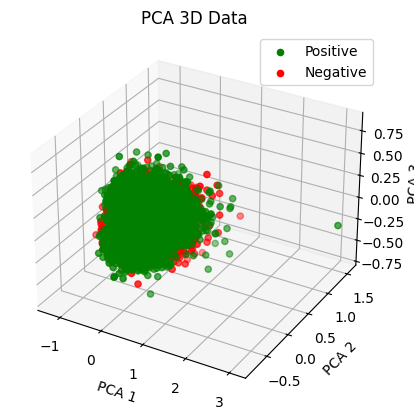

In [39]:
#Gets reduced positive and negative data (3d)
positive, negative = PCA_set_up(3)

# Plots the 3D Data
fig = plt.figure()
axis = fig.add_subplot(projection='3d')
axis.scatter(positive[:, 0], positive[:, 1], positive[:, 2], color='green', label='Positive')
axis.scatter(negative[:, 0], negative[:, 1], negative[:, 2], color='red', label='Negative')
axis.legend()
axis.set_title('PCA 3D Data')
axis.set_xlabel('PCA 1')
axis.set_ylabel('PCA 2')
axis.set_zlabel('PCA 3')
plt.show()